# Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Run Codes Locally on Your Machine**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.

# Backtesting Options Spread Strategy

In the previous section, you have learnt how to predict whether the SPY will move up (1) or down (0) on the next trading day with the help of an ML model. In this notebook, you will use these predictions and deploy the bull call spread strategy on the SPX end-of-month options contracts when the SPY is expected to move upwards. Note that the underlying asset for the options contracts is the S&P 500 and we will be using the SPY ETF as it replicates the performance of the S&P 500 index.

This notebook is structured as follows:
1. [Import Libraries](#libraries)
1. [Read the Data](#data)
1. [Determine Entry and Exit Signals](#entry-exits)
1. [Strategy Parameters](#params)
1. [Backtesting](#backtesting)

<a id='libraries'></a>
## Import Libraries

In [1]:
# For data manipulation
import numpy as np
import pandas as pd

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')

# To ignore warning statements
import warnings
warnings.filterwarnings('ignore')

# Helper functions
import sys
sys.path.append('..')
from data_modules.ml_options_util_quantra import get_premium, setup_call_spread

<a id='data'></a>
## Read the Data

In order to create a bull call spread strategy, we need the options data and its underlying asset price data. We import the end-of-month options chain data of the SPY from the pickle file `spx_eom_expiry_options_2010_2022.bz2`. And similarly, we get the data for the predictions made on the underlying asset (i.e. SPY) by importing the data present in the CSV file `spy_signals_2018_2022.csv`.

In [2]:
# Import the option chain data for S&P 500
options_data = pd.read_pickle(
    '../data_modules/spx_eom_expiry_options_2010_2022.bz2')

# Remove unnecessary square brackets and spaces from column names
options_data.columns = options_data.columns.str.replace(
    "[", "").str.replace("]", "").str.strip()

# Display the options data
options_data.tail()

,STRIKE,STRIKE_DISTANCE_PCT,C_LAST,UNDERLYING_LAST,P_LAST,EXPIRE_DATE,DTE,C_DELTA,C_GAMMA,C_VEGA,C_THETA,C_RHO,C_IV,P_DELTA,P_GAMMA,P_VEGA,P_THETA,P_RHO,P_IV
[QUOTE_DATE],,,,,,,,,,,,,,,,,,,
2022-09-30,6300.0,0.755,0.03,3589.7,2155.22,2022-09-30,0.0,0.00001,0.0,0.00073,-0.02515,-0.00046,3.467740,-0.81918,-0.00001,0.33024,-4.34966,-0.03739,8.585380
2022-09-30,6400.0,0.783,0.00,3589.7,0.00,2022-09-30,0.0,0.00000,0.0,0.00072,-0.02517,0.00048,3.560500,-0.81333,-0.00004,0.33582,-4.34954,-0.03792,8.895180
2022-09-30,6500.0,0.811,0.00,3589.7,0.00,2022-09-30,0.0,0.00000,0.0,0.00131,-0.02465,-0.00022,3.645170,-0.80773,0.00000,0.34053,-4.35038,-0.03851,9.204630
2022-09-30,6600.0,0.839,0.05,3589.7,0.00,2022-09-30,0.0,0.00004,0.0,0.00105,-0.02518,-0.00038,3.734590,-0.80204,0.00002,0.34486,-4.34980,-0.03926,9.514720
2022-09-30,6700.0,0.866,0.05,3589.7,0.00,2022-09-30,0.0,0.00000,0.0,0.00090,-0.02465,-0.00049,3.816150,-0.79602,0.00004,0.35040,-4.34985,-0.04006,9.824500


In [3]:
# Import the underlying (SPY) signal data
data = pd.read_csv('../data_modules/spy_signals_2018_2022.csv', index_col=0)

# Display the predicted signals
data['predicted_signal'].tail()

Date
2022-06-23    1
2022-06-24    0
2022-06-27    1
2022-06-28    1
2022-06-29    1
Name: predicted_signal, dtype: int64

<a id='entry-exits'></a>
## Determine Entry and Exit Signals

We will set the entry and signals on the basis of the forecasted values of the SPY ETF we obtained by using the decision tree classifier model in the notebook 'Implementing a Decision Tree Classifier'

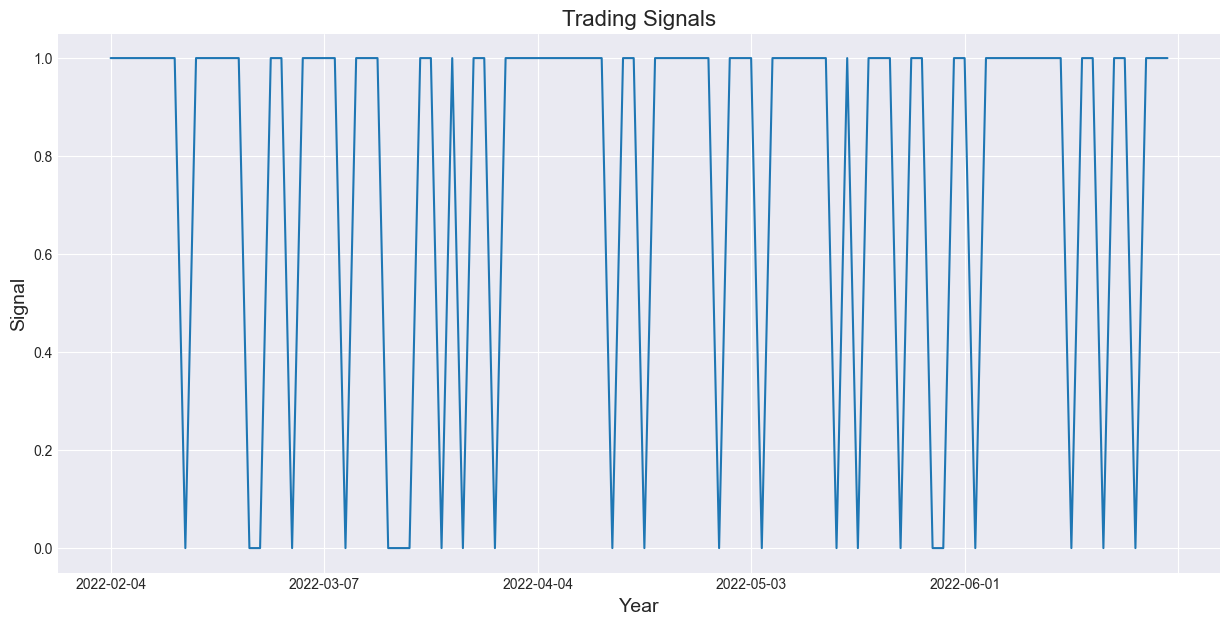

In [4]:
# Set the signal values based on the predicted values of the underlying
data['signal'] = data['predicted_signal']

# Plot the signals
plt.figure(figsize=(15, 7))
data.iloc[-100:].signal.plot()

# Set the title and axes labels
plt.title('Trading Signals', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Signal', fontsize=14)
plt.show()

In the above plot, if the value of the signal is 1, it indicates that the SPY is forecasted to move upwards on the next trading day. Hence, setting up a bull call spread would be a good idea to benefit from the upward movement in prices. On the other hand, when the signal is 0, it indicates that the SPY is expected to move downwards on the upcoming trading day. And hence, you can consider closing the bull call spread position on such days.

**Note-** The prediction generated is for the next day. For example, if the prediction generated as "1" on 29th September, 2022 then it means that an upmove is being predicted for 30th September, 2022. Note that for the sake of calculations, we assume that we have bought the asset at the close of the 29th September. This is for backtesting purposes only.

<a id='params'></a>
## Strategy Parameters

We will store the strategy parameters in a variable called `config` which will then be utilised at the time of backtesting.

Proper risk management is essential while trading any strategy in a systematic manner to avoid running into huge losses and this can be achieved by placing stop-loss and take-profit for each trade. Hence, we have set the stop-loss and take-profit at 40% of the net entry premium respectively. You can try changing this to see how it affects the backtest results. However, if the SL is kept too low, then it might get hit too frequently. On the other hand, if we keep it too high, then it might not hit at all. 

The `days_to_exit_before_expiry` is arbitrarily set to 1 for now and can be changed if you want to exit the trade a few days before expiry in order to avoid huge MTM swing when the expiry approaches. 

In [5]:
config = {
    'stop_loss_percentage': 40,
    'take_profit_percentage': 40,
    'days_to_exit_before_expiry': 1
}

<a id='backtesting'></a>
## Backtesting
We will loop over each date in the data, set up the bull call spread when entry conditions are met, exit before the expiry and update the trade in round trips. `mark_to_market` dataframe contains the premiums of the strategy on each date between the entry date and exit date.

We will backtest the bull call spread strategy using the following steps:

**Step-1**: Create dataframes `round_trips_details`, `trades` and `mark_to_market` for storing round trips, trades and mtm.

**Step-2**: Define a function `add_to_mtm` which stores daily mark_to_market values for the strategy. It takes existing `mark_to_market` dataframe, `option_strategy` which is the call spread strategy in this case and `trading_date` as inputs.

**Step-3**: Initialise `current_position`, `trade_num` which is basically the number of trades, `cum_pnl` to 0 and set the `exit_flag` to `False`. 

**Step-4**: We also set the `start_date` for backtesting.

In [6]:
# Create dataframes for round trips, storing trades, and mtm
round_trips_details = pd.DataFrame()
trades = pd.DataFrame()
mark_to_market = pd.DataFrame()

# Function for calculating mtm


def add_to_mtm(mark_to_market, option_strategy, trading_date):
    option_strategy['Date'] = trading_date
    mark_to_market = pd.concat([mark_to_market, option_strategy])
    return mark_to_market


# Initialise current position, number of trades and cumulative pnl to 0
current_position = 0
trade_num = 0
cum_pnl = 0

# Set exit flag to False
exit_flag = False

# Set start date for backtesting
start_date = data.index[0]

Perform the following steps iteratively for the dates in the backtest period.

**Step-5**: For a given date, if there is no open position and entry conditions are met, we will set up the call spread.

**Step-6**: For a given date, if there is an open position we exit the trade if the given date is an expiry and update round trips.

In [7]:
for i in data.loc[start_date:].index:

    if (current_position == 0) & (data.loc[i, 'signal'] != 0):

        # Set up option spread strategy
        try:
            options_data_daily = options_data.loc[i]
        except:
            continue

        # If signal is 1 we will set up bull call spread
        if data.loc[i, 'signal'] == 1:
            spread = setup_call_spread(options_data_daily, 10)

        else:
            continue

        # Check that the last price of any of the leg of the spread should be greater than 0
        if (spread.premium.isna().sum() > 0) or ((spread.premium == 0).sum() > 0):
            print(
                f"\x1b[31mStrike price not liquid so we will ignore this trading opportunity {i}\x1b[0m")
            continue

        # Populate the trades dataframe
        trades = spread.copy()
        trades['entry_date'] = i
        trades.rename(columns={'premium': 'entry_price'}, inplace=True)

        # Calculate net premium
        net_premium = round((spread.position * spread.premium).sum(), 1)

        # Compute SL and TP for the trade
        premium_sign = np.sign(net_premium)
        sl = net_premium * \
            (1 - config['stop_loss_percentage']*premium_sign/100)
        tp = net_premium * \
            (1 + config['take_profit_percentage']*premium_sign/100)

        # Update current position
        current_position = data.loc[i, 'signal']

        # Update mark_to_market dataframe
        mark_to_market = add_to_mtm(mark_to_market, spread, i)

        # Increase number of trades by 1
        trade_num += 1
        print("-"*30)

        # Print trade details
        print(
            f"Trade No: {trade_num} | Entry | Date: {i} | Premium: {net_premium*-1} | Position: {current_position}")

    elif current_position != 0:

        # Update net premium
        try:
            options_data_daily = options_data.loc[i]
        except:
            continue

        spread['premium'] = spread.apply(
            lambda r: get_premium(r, options_data_daily), axis=1)
        net_premium = (spread.position * spread.premium).sum()

        # Update mark_to_market dataframe
        mark_to_market = add_to_mtm(mark_to_market, spread, i)

        # Exit the trade if any of the exit condition is met
        if data.loc[i, 'signal'] != current_position:
            exit_type = 'Expiry or Signal Based'
            exit_flag = True

        elif net_premium < sl:
            exit_type = 'SL'
            exit_flag = True

        elif net_premium > tp:
            exit_type = 'TP'
            exit_flag = True

        if exit_flag:

            # Check that the data is present for all strike prices on the exit date
            if spread.premium.isna().sum() > 0:
                print(
                    f"Data missing for the required strike prices on {i}, Not adding to trade logs.")
                current_position = 0
                continue

            # Append the trades dataframe
            trades['exit_date'] = i
            trades['exit_type'] = exit_type
            trades['exit_price'] = spread.premium

            # Add the trade logs to round trip details
            round_trips_details = pd.concat([round_trips_details, trades])

            # Calculate net premium at exit
            net_premium = round((spread.position * spread.premium).sum(), 1)

            # Calculate net premium on entry
            entry_net_premium = (trades.position * trades.entry_price).sum()

            # Calculate pnl for the trade
            trade_pnl = round(net_premium - entry_net_premium, 1)

            # Calculate cumulative pnl
            cum_pnl += trade_pnl
            cum_pnl = round(cum_pnl, 1)

            # Print trade details
            print(
                f"Trade No: {trade_num} | Exit Type: {exit_type} | Date: {i} | Premium: {net_premium} | PnL: {trade_pnl} | Cum PnL: {cum_pnl}")

            # Update current position to 0
            current_position = 0

            # Set exit flag to false
            exit_flag = False

------------------------------
Trade No: 1 | Entry | Date: 2018-07-20 | Premium: -17.0 | Position: 1
Trade No: 1 | Exit Type: TP | Date: 2018-07-24 | Premium: 26.0 | PnL: 9.0 | Cum PnL: 9.0
------------------------------
Trade No: 2 | Entry | Date: 2018-07-26 | Premium: -8.6 | Position: 1
Trade No: 2 | Exit Type: SL | Date: 2018-07-27 | Premium: 1.2 | PnL: -7.4 | Cum PnL: 1.6
------------------------------
Trade No: 3 | Entry | Date: 2018-07-30 | Premium: -7.8 | Position: 1
Trade No: 3 | Exit Type: Expiry or Signal Based | Date: 2018-07-31 | Premium: 16.5 | PnL: 8.7 | Cum PnL: 10.3
------------------------------
Trade No: 4 | Entry | Date: 2018-08-01 | Premium: -29.6 | Position: 1
Trade No: 4 | Exit Type: Expiry or Signal Based | Date: 2018-08-02 | Premium: 28.0 | PnL: -1.6 | Cum PnL: 8.7
------------------------------
Trade No: 5 | Entry | Date: 2018-08-03 | Premium: -23.4 | Position: 1
Trade No: 5 | Exit Type: Expiry or Signal Based | Date: 2018-08-07 | Premium: 34.8 | PnL: 11.4 | Cu

<a id='pnl'></a>
### Compute and Visualise the Cumulative PnL

We will now compute and plot the cumulative strategy returns based on the trades taken above.

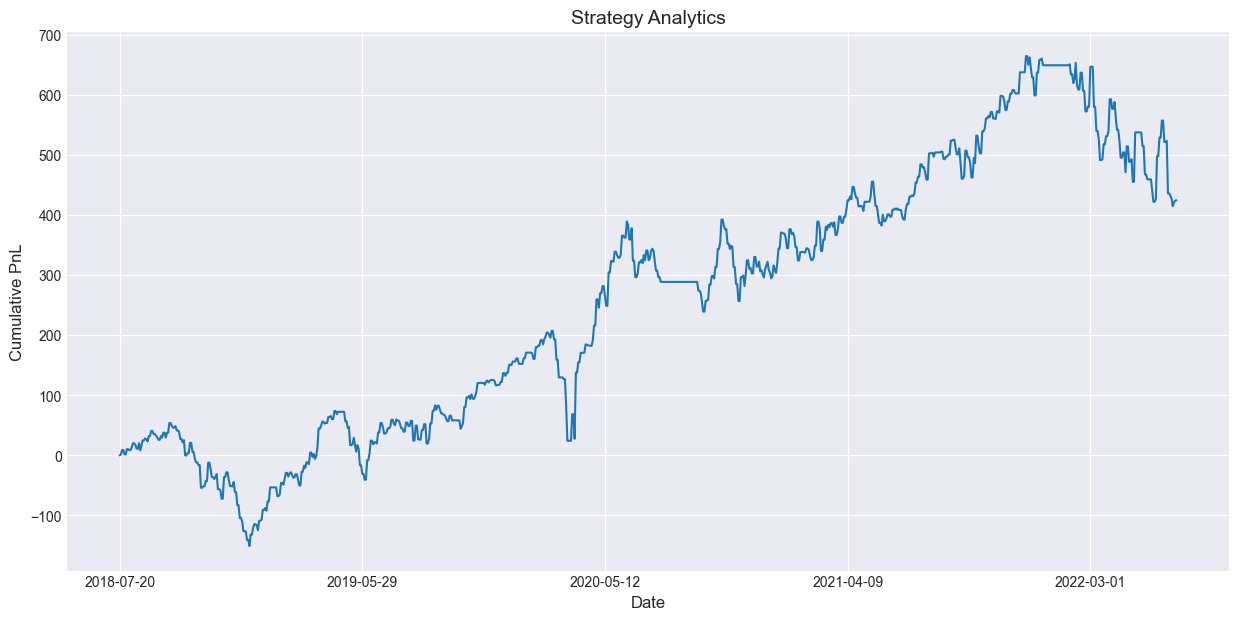

In [8]:
# Calculate net premium based on positions
mark_to_market['net_premium'] = mark_to_market.position * \
    mark_to_market.premium

# Strategy analytics
analytics = pd.DataFrame()
analytics['change_in_pnl'] = mark_to_market.groupby(
    'Date').net_premium.sum().diff()
analytics.loc[analytics.index.isin(
    round_trips_details.entry_date), 'change_in_pnl'] = 0

# Calculate cumulative PnL
analytics['cum_pnl'] = analytics['change_in_pnl'].cumsum()

# Plot cumulative PnL
plt.figure(figsize=(15, 7))
analytics['cum_pnl'].plot()

# Set labels for the plot
plt.title("Strategy Analytics", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative PnL", fontsize=12)
plt.show()

In the above plot, you can see that the strategy faced a substantial drawdown during the initial period. However, the performance seemed to recover from 2019 onwards and the current value is $424.

In [9]:
# Display round trip details
round_trips_details.tail()

,Option Type,Strike Price,position,entry_price,entry_date,exit_date,exit_type,exit_price
1,CE,4140,-1,0.22,2022-05-31,2022-06-01,TP,98.94
0,CE,4110,1,102.70,2022-06-03,2022-06-13,SL,7.94
1,CE,4520,-1,2.28,2022-06-03,2022-06-13,SL,0.40
0,CE,3670,1,86.50,2022-06-16,2022-06-21,Expiry or Signal Based,81.80
1,CE,4020,-1,4.90,2022-06-16,2022-06-21,Expiry or Signal Based,3.90


### Save the Files on Your Disk

You can run the following code cell in order to store round trip details and MTM data to CSV files. We will be importing the same in the upcoming notebooks.

<b>The following cell will not run in the browser. Download this notebook and convert the cell to "Code" type.</b>

## Conclusion

In this notebook we backtested a call spread strategy which takes trade based on the predicted values of the underlying asset. You also learned how to exit the trades based on stop-loss, take-profit or on expiry basis. In the upcoming notebooks, we will analyse the strategy in a more detailed manner by calculating the trade level analytics. <br><br>